# Colab Setup

In [1]:
!pip install -q --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/NoLaTeX

/content/drive/MyDrive/Colab Notebooks/NoLaTeX


In [3]:
!pwd

/home/chilleex/code/ChilleeX/NoLaTeX/notebooks


In [1]:
!pip install -e .

Obtaining file:///home/chilleex/code/ChilleeX/NoLaTeX
  Preparing metadata (setup.py) ... done
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
  Attempting uninstall: nolatex
    Found existing installation: nolatex 0.0.1
    Uninstalling nolatex-0.0.1:
      Successfully uninstalled nolatex-0.0.1
  Running setup.py develop for nolatex


In [ ]:
#uncoment to have time displayed on every cell

# !pip install ipython-autotime
# %load_ext autotime

# Local Setup

In [ ]:
!pip install -e ..

# Imports

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import tensorflow as tf
#import functions
from keras.utils import load_img
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.models import load_model

from keras_cv import visualization
from keras_cv.layers import Resizing, NonMaxSuppression
from keras_cv.callbacks import PyCOCOCallback
from keras_cv.models import YOLOV8Detector

from nolatex.ml_logic.utils import load_dataset

import cv2

2024-03-16 14:53:45.866939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 14:53:46.787226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/brunovsf/.pyenv/versions/3.10.6/envs/nolatex/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define Paths

In [2]:
json_path = "../raw_data/archive/batch_1/JSON/kaggle_data_1.json"
img_dir = "../initial_test_data/batch_1_salmple100"

# Load Data into the right format

In [3]:
dataset, class_mapping, low_contrast_imgs = load_dataset(img_dir=img_dir, json_path=json_path)

num_classes = len(class_mapping)

2024-03-16 15:01:23.032169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-16 15:01:23.071175: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-03-16 15:01:23.073160: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 653330448 exceeds 10% of free system memory.


In [ ]:
from sys import getsizeof
getsizeof(dataset)

# Image Resizing

In [4]:
inference_resizing = Resizing(
    320, 320, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
)

In [5]:
dataset_resized = inference_resizing(dataset)

2024-03-16 15:02:07.390773: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 653330448 exceeds 10% of free system memory.


# Starting the model

In [15]:
model_dir = "../models"
model_name = "name" + ".keras"
model_path = os.path.join(model_dir, model_name)

#Set model Params here
backbone_model = "resnet50_imagenet"
#Optimizer Params
base_lr = 0.005
momentum = 0.9
global_clipnorm = 10.0
#Loss Params
classification_loss = "binary_crossentropy"
box_loss = "ciou"
#Train Params
number_epochs = 10
batch_size = 32

In [7]:
model = YOLOV8Detector.from_preset(
    backbone_model,
    bounding_box_format="xyxy",
    num_classes=num_classes,
)

100%|██████████| 777/777 [00:00<00:00, 1.19MB/s]
100%|██████████| 90.3M/90.3M [00:03<00:00, 24.9MB/s]


In [8]:
# including a global_clipnorm is extremely important in object detection tasks
optimizer = SGD(
    learning_rate=base_lr, momentum=momentum, global_clipnorm=global_clipnorm
)

In [9]:
model.compile(
    classification_loss=classification_loss,
    box_loss=box_loss,
    optimizer=optimizer,
)

In [ ]:
#Needs to be tested
# coco_metrics_callback = PyCOCOCallback(
#     resized_data, bounding_box_format="xyxy"
# )

In [13]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(model_dir, "cp-{epoch:04d}.weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Calculate the number of batches per epoch
#n_batches = len(dataset['images']) / batch_size
#n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq="epoch"
    #save_freq=5*n_batches
    )

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

In [16]:
#by just following the example notebook I managed to train 1 epoch in 45 minutes
#did not manage to run fit with 16 images, colab breaks when reaching around the 3 min mark
model.fit(
    dataset_resized,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=number_epochs,
    #batch_size=batch_size,
    callbacks=[cp_callback]
    #callbacks=[coco_metrics_callback]
)

model.save(model_path)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - loss: 25143.4492 
Epoch 1: saving model to cp-0001.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 135s 37s/step - loss: 25093.6250
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - loss: 23349.1953 
Epoch 2: saving model to cp-0002.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 112s 37s/step - loss: 23238.5195
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - loss: 20321.8379 
Epoch 3: saving model to cp-0003.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 112s 37s/step - loss: 20179.5156
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - loss: 16921.1094 
Epoch 4: saving model to cp-0004.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 111s 37s/step - loss: 16777.8223
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - loss: 13704.0654 
Epoch 5: saving model to cp-0005.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 111s 37s/step - loss: 13584.2090
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - loss: 10734.1777 
Epoch 6: saving model to cp-0006.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 110s 37s/step

# Loading Models

In [ ]:
# Restore the weights

#Important model needs to be initialized first
model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
# Loading a complete model

new_model = load_model('my_model.keras')

# Ploting predict

In [17]:
from nolatex.ml_logic.preprocessing import image_preprocessing

In [25]:
test_image_path = "../initial_test_data/batch_1_salmple100/0a0a8e28-4f48-4bad-8627-cbdde64c12bb.jpg"
image_test = image_preprocessing(test_image_path)
image_test_resized = inference_resizing([image_test])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


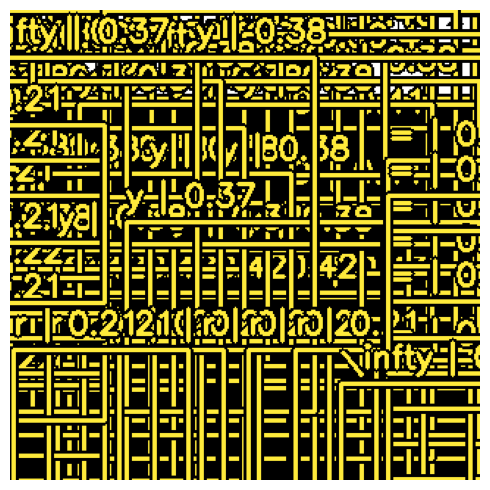

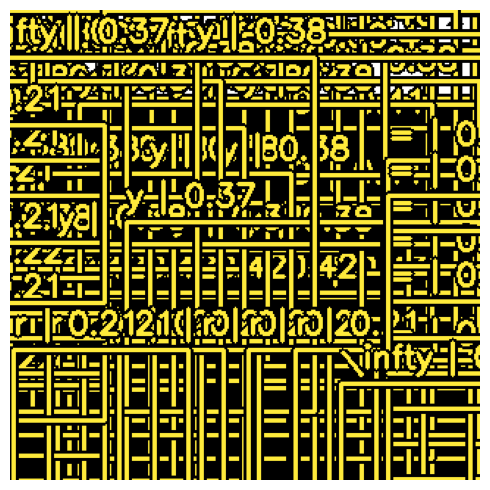

In [26]:
#Simple visualization (Already tested)
y_pred = model.predict(image_test_resized)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_test_resized,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xyxy",
    class_mapping=class_mapping,
)

In [6]:
print(f"Boxes shape: {dataset_resized['bounding_boxes']['boxes'].shape}")
print(f"Classes shape: {dataset_resized['bounding_boxes']['classes'].shape }")
print(f"Images shape: {dataset_resized['images'].shape}")

Boxes shape: (1, None, 4)
Classes shape: (1, None)
Images shape: (1, 640, 640, 3)


In [6]:
img_bbox = {
    'boxes' : dataset['bounding_boxes']['boxes'],
    'classes' : dataset['bounding_boxes']['classes']
}

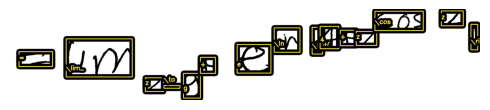

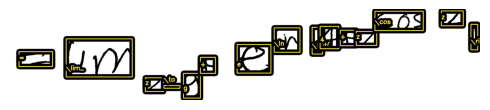

In [7]:
visualization.plot_bounding_box_gallery(
    dataset['images'],
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=img_bbox,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xyxy",
    class_mapping=class_mapping,
)

In [16]:
image = dataset_resized['images'][0]
boxes = dataset_resized['bounding_boxes']['boxes'][0]

In [17]:
draw_bounding_boxes(
    image= image,
    boxes= dataset_resized['bounding_boxes']['boxes'][0],
    width= 1
)


TypeError: Tensor expected, got <class 'tensorflow.python.framework.ops.EagerTensor'>

In [15]:
# draw all annotation bounding boxes on an image
def annotate_image(img, boxes):
    for box in boxes:
        x_min = boxes[2]
        y_min = boxes[3]
        x_max = boxes[0]
        y_max = boxes[1]
        print(box)
        cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color= (100,100,255))

img = dataset_resized['images'][0]
data = dataset_resized['bounding_boxes']['boxes'].numpy()
print(data.shape)
annotate_image(img, data)
plt.imshow(img)
plt.title(img.shape)

(1, 0, 0)


IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
#Needs to be tested
model.prediction_decoder = NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)
visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

# visualization_ds on example notebook is en evaluation set
# visualization_ds = eval_ds.unbatch()
# visualization_ds = visualization_ds.ragged_batch(16)
# visualization_ds = visualization_ds.shuffle(8)

#Experimental Stuff


In [ ]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xyxy", dataset=visualization_ds
        )
